In [1]:
import numpy as np
from shapely.geometry import Polygon, LineString, Point
import matplotlib.pyplot as plt
from GISio import shp2df
from descartes import PolygonPatch

% matplotlib inline

### `shapely`
#### make some arbitrary polygons
test them for intersection; demonstrate some other methods
see: http://toblerity.org/shapely/manual.html#predicates-and-relationships


In [2]:
p1 = Polygon(((0, 0), (0, 1), (1, 1), (1, 0)))
p2 = Polygon(((0.5, 0.5), (0.5, 1.5), (1.5, 1.5), (1.5, 0.5), (0.5, 0.5)))
p1.intersects(p2)

True

In [3]:
p1.within(p2)

False

In [4]:
p1.touches(p2)

False

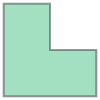

In [5]:
dif = p1.difference(p2)
dif

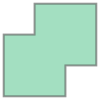

In [6]:
un = p1.union(p2)
un

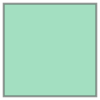

In [7]:
ints = p1.intersection(p2)
ints

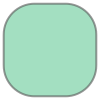

In [8]:
buf = ints.buffer(0.5, )
buf

#### make a quick and dirty plot that illustrates the exterior rings of the shapes together

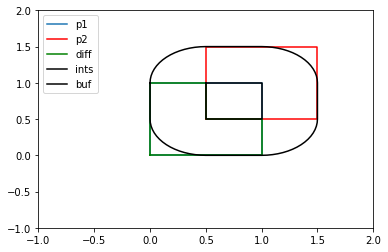

In [9]:
fig, ax = plt.subplots()
plt.plot(*zip(*p1.exterior.coords), label='p1')
plt.plot(*zip(*p2.exterior.coords), color='r', label='p2')
plt.plot(*zip(*dif.exterior.coords), color='g', label='diff')
plt.plot(*zip(*ints.exterior.coords), color='k', label='ints')
plt.plot(*zip(*buf.exterior.coords), color='k', label='buf')
ax.set_xlim(-1, 2)
ax.set_ylim(-1, 2)
plt.legend(loc=2)

#### read in the Yahara Lakes shapefile

In [10]:
df = shp2df('data/YaharaLakes.shp')


reading data/YaharaLakes.shp...
--> building dataframe... (may take a while for large shapefiles)


### `descartes`
#### make a patch (plottable by `pyplot`) of a single geometry using `PolygonPatch`

In [11]:
PolygonPatch(df.geometry[0])

In [12]:
from matplotlib.collections import PatchCollection

### make a patch collection of all the lakes

In [13]:
list(df.geometry[0].exterior.coords)

[(-89.38954830502291, 43.063793399823055, 0.0),
 (-89.38945470502301, 43.063564733156795, 0.0),
 (-89.38936110502317, 43.063473333156935, 0.0),
 (-89.3892987050233, 43.06331333315717, 0.0),
 (-89.38855010502442, 43.06251333315839, 0.0),
 (-89.38848777169119, 43.06242179982519, 0.0),
 (-89.38789530502544, 43.06187319982604, 0.0),
 (-89.38789517169215, 43.061324533160246, 0.0),
 (-89.38801990502526, 43.06105013316068, 0.0),
 (-89.38801977169192, 43.060661533161294, 0.0),
 (-89.3878949716921, 43.060547133161435, 0.0),
 (-89.3873961716929, 43.060615799827985, 0.0),
 (-89.3873027050264, 43.060821599827705, 0.0),
 (-89.38705317169342, 43.060821599827705, 0.0),
 (-89.38695970502692, 43.0607529998278, 0.0),
 (-89.38677250502718, 43.06057019982808, 0.0),
 (-89.3865231050276, 43.060272999828555, 0.0),
 (-89.38583697169531, 43.05956439982964, 0.0),
 (-89.38527570502953, 43.058878599830734, 0.0),
 (-89.38508857169649, 43.058695799831014, 0.0),
 (-89.38508850502984, 43.058489999831295, 0.0),
 (-89.

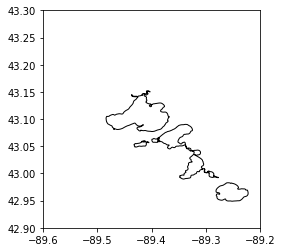

In [14]:
fig, ax = plt.subplots()
collection = PatchCollection([PolygonPatch(p) for p in df.geometry],
                             facecolor='w', edgecolor='k')
ax.add_collection(collection)
ax.set_xlim(-89.6, -89.2)
ax.set_ylim(42.9, 43.3)
ax.set_aspect(1)

### `pyproj`

In [15]:
import pyproj
from functools import partial
from shapely.ops import transform

#### proj4 strings for source and destination coordinate systems

In [16]:
projection1 = '+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs'
projection2 = '+init=epsg:26916'

#### make `pyproj.Proj` objects

In [17]:
pr1 = pyproj.Proj(projection1, errcheck=True, preserve_units=True)
pr2 = pyproj.Proj(projection2, errcheck=True, preserve_units=True)

#### transform of a single point using pyproj

In [18]:
pyproj.transform(pr1, pr2, -89, 43)

(336980.9299175093, 4762755.641571694)

#### partial function for repeated application of the transform
the other two arguments are the x and y coordinates

In [19]:
project = partial(pyproj.transform, pr1, pr2)
project

functools.partial(<function transform at 0x11eb00158>, <pyproj.Proj object at 0x11ebd12e8>, <pyproj.Proj object at 0x11ebd1348>)

#### `shapely.ops.transform` takes two arguments  
1) a function such as the one above that can transform a coorindate pair  
2) a shapely geometry object

It then applies the transformation to each coordinate represented in the geometry object. We build on this further by looping over the geometry objects in a list comprehension.

In [20]:
geomsutm = [transform(project, g) for g in df.geometry]

### Reprojection using the `GIS_utils` `projectdf` macro

In [21]:
from GISops import projectdf

In [22]:
geoms = projectdf(df, projection1, projection2)

In [23]:
from GISio import shp2df, df2shp

### Reprojecting a shapefile using `projectdf`

In [24]:
df = shp2df('data/YaharaLakes.shp')
geoms = projectdf(df, projection1, projection2)
df['geometry'] = geoms
df2shp(df, 'data/YaharaLakes2.shp', proj4=projection2)


reading data/YaharaLakes.shp...
--> building dataframe... (may take a while for large shapefiles)
writing data/YaharaLakes2.shp...
